# Seismic data analysis (cross-correlation) with TensorFlow

- author: Léonard Seydoux
- date: 07/04/2020
- meeting: ISTerre Groupe Calcul<br>

This notebook makes use of `tensorflow-gpu 2.0.0` with `cudatoolkit 10.0.130` and `cudnn 7.6.5`. In order to install TensorFlow correctly within your conda environment, please visit https://www.tensorflow.org/install.

In [1]:
import numpy as np
import obspy
import tensorflow as tf
import time

from scipy import signal

In [2]:
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## TensorFlow settings

- TensorFlow is very chatty, you can set the logger level to `ERROR` in order to avoid warnings and info logs.
- The purpose of this notebook is to make use of a GPU, so first test is a GPU is available.
- Ensure that TensorFlow is executing eagerly (should be the case by default in versions 2+).

In [3]:
tf.get_logger().setLevel('ERROR')
is_gpu_available = tf.test.is_gpu_available()
is_executing_eagerly = tf.executing_eagerly()
print('TensorFlow is seeing a GPU:', is_gpu_available)
print('TensorFlow is executing eagerly:', is_executing_eagerly)

TensorFlow is seeing a GPU: True
TensorFlow is executing eagerly: True


## Routines

- A seismic data reader with controllable precision
- An automatic date ticker

In [4]:
def synchronize(stream):
    """Interpolate stream onto same values."""
    # Duplicate stream
    stream_i = stream.copy()

    # Padding ends
    start = obspy.UTCDateTime(2010, 1, 1)
    end = obspy.UTCDateTime(2010, 1, 10)
    sampling = stream[0].stats.sampling_rate
    npts = 1555199
    stream_i.trim(start, end, pad=True, fill_value=0, nearest_sample=False)

    # Interpolating ends
    for tr, tr_i in zip(stream, stream_i):
        t = tr.times() / 24 / 3600 + tr.stats.starttime.matplotlib_date
        shift = tr_i.stats.starttime - start
        tr_i.interpolate(sampling, start=start, npts=npts, time_shift=-shift, pad=True, fill_value=0)
        ti = tr_i.times() / 24 / 3600 + tr_i.stats.starttime.matplotlib_date
        tr_i.data = np.interp(ti, t, tr.data)

    return stream_i


In [5]:
def read_seismograms(filename, dtype=np.float32):
    """Read seismograms with obpsy, returns time vector and array data.
    
    The data is cast to np.float32 in order to ensure GPU-compatibility.
    
    Arguments
    ---------
    filename: str
        Path to the seismic files (accepts wildcards).
        
    Returns
    -------
    t: np.ndarray
        Time vector in matplotlib times.
        
    x: np.ndarray
        Data array of shape `(n_stations, n_times)`.
    """
    stream = obspy.read(filename)
    stream.merge(method=1, fill_value=0)
    for trace in stream:
        if trace.stats.npts < 1.4e6:
            stream.remove(trace)
    stream.trim(obspy.UTCDateTime(2010, 1, 1), obspy.UTCDateTime(2010, 1, 10))
    stream = synchronize(stream)
    t = stream[0].times() / 24 / 3600 + stream[0].stats.starttime.matplotlib_date
    x = [trace.data.astype(dtype) for trace in stream]
    x = np.array([trace / np.linalg.norm(trace) for trace in x])
    kna = [trace.stats.station for trace in stream]
    lon = [trace.stats.sac['stlo'] for trace in stream]
    lat = [trace.stats.sac['stla'] for trace in stream]
    return t, x, (kna, lon, lat)

In [6]:
def dateticks(axis):
    """Add date ticks to given axes.
    
    Arguments
    ---------
    axis: matplotlib.pyplot.Axis
        The axis of a given Axes (e.g. `ax.xaxis` or `ax.yaxis`).
    """
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    axis.set_major_locator(locator)
    axis.set_major_formatter(formatter)
    pass

## Read and show seismogram

- A seismic data reader with controllable precision
- An automatic date ticker

In [21]:
# t, x, stations = read_seismograms('data-usarray-1.5Hz/*quiet*')
t, x, (names, lon, lat) = read_seismograms('sac/continuous0*/processed/*')
x = x[::5]
names = names[::5]
lon = lon[::5]
lat = lat[::5]
print('Loaded {} seismograms with {} samples each.'.format(*x.shape))

Loaded 6 seismograms with 1555199 samples each.


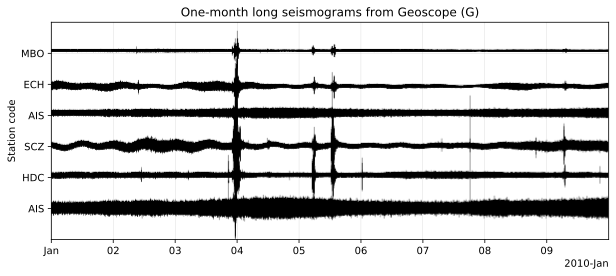

In [23]:
fig, ax = plt.subplots(1, figsize=(10, 4))
for i, trace in enumerate(x):
    trace /= .01 * np.linalg.norm(trace)
    ax.plot(t, trace + i, lw=.2, c='k', rasterized=True)

ax.set_xlim(t[[0, -1]])
ax.grid(lw=.2)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_ylim([-1, len(names)])
dateticks(ax.xaxis)
ax.set_ylabel('Station code')
ax.set_title('One-month long seismograms from Geoscope (G)');

## Calculate a spectrogram

Two functions, one with `scipy` based on CPU, the other one with `tensorflow` with GPU. Note that because TensorFlow have to be asked for the numpy 


In [24]:
@tf.function
def spectrogram_with_tf(t, x, window_duration=10, whiten=False):
    """Calculate a spectrogram with tensorflow."""
    fs = 1 / (t[1] - t[0]) / 24 / 3600
    nbin = int(window_duration * fs)
    step = nbin // 4
    nfft = 2 * nbin + 1
    with tf.device('/GPU:0'):
        stft = tf.signal.stft(x, frame_length=nbin, frame_step=step, fft_length=nfft)
        if whiten is True:
            stft /= tf.complex((tf.math.abs(stft) + 1e-4), 0. * tf.math.abs(stft))
    return stft

In [25]:
def spectrogram_with_sp(t, x, window_duration=10, whiten=False):
    """Calculate a spectrogram with tensorflow."""
    fs = 1 / (t[1] - t[0]) / 24 / 3600
    nbin = int(window_duration * fs)
    overlap = 3 * (nbin // 4)
    step = nbin // 4
    nfft = 2 * nbin + 1
    _, _, stft = signal.stft(x, nperseg=nbin, noverlap=overlap, nfft=nfft, padded=False, boundary=None)
    if whiten is True:
        stft /= (np.abs(stft) + 1e-4)
    return np.transpose(stft, [0, 2, 1])

In [26]:
window_duration = 7000  # seconds

Run a second time the above cell in order to see that only the first execution takes a while. The following ones are sometimes 100 times faster than the CPU.

In [36]:
%%time
xfft_tf = spectrogram_with_tf(t, x, window_duration)

CPU times: user 125 ms, sys: 28.2 ms, total: 154 ms
Wall time: 152 ms


In [38]:
%%time
xfft_sp = spectrogram_with_sp(t, x, window_duration)

CPU times: user 1.39 s, sys: 56 ms, total: 1.44 s
Wall time: 1.44 s


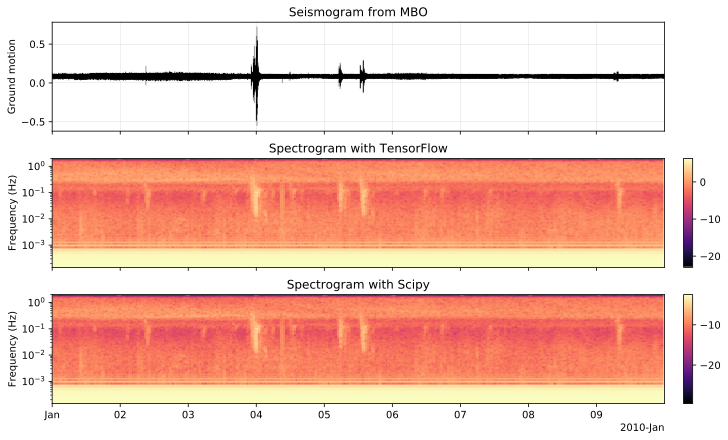

In [39]:
fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True, constrained_layout=True)

station_id = 5
fs = 1 / (t[1] - t[0]) / 24 / 3600
img_kw = dict(aspect='auto', origin='lower', cmap='magma', extent=[t[0], t[-1], fs / xfft_tf.shape[2], fs])

ax[0].plot(t, x[station_id], rasterized=True, lw=.2, c='k')
img1 = ax[1].imshow(np.log(np.abs(xfft_tf[station_id] + 1e-10)).T, **img_kw)
img2 = ax[2].imshow(np.log(np.abs(xfft_sp[station_id] + 1e-10)).T, **img_kw)

# Cosmetics
for a, img in zip(ax[1:], [img1, img2]):
    plt.colorbar(img, ax=a)
    a.set_yscale('log')
    a.set_ylabel('Frequency (Hz)')

ax[0].grid(lw=.2)
ax[0].set_ylabel('Ground motion')
ax[0].set_title('Seismogram from {}'.format(names[station_id]))
ax[1].set_title('Spectrogram with TensorFlow')
ax[2].set_title('Spectrogram with Scipy')
dateticks(ax[2].xaxis)

## Going further with cross-correlation

In [40]:
@tf.function
def xcorr_with_tf(stft):
    """Calculate cross-correlation from spectrogram."""
    with tf.device('/GPU:0'):
        cs = tf.einsum('ink,jnk->ijnk', stft, tf.math.conj(stft))
        csd = tf.math.reduce_sum(cs, axis=2)
        xcorr = tf.signal.fftshift(tf.signal.irfft(csd), axes=-1)
    return xcorr

In [41]:
def xcorr_with_sp(stft):
    """Calculate cross-correlation from spectrogram."""
    cs = np.einsum('ink,jnk->ijnk', stft, np.conj(stft))
    csd = np.sum(cs, axis=2)
    xcorr = np.fft.fftshift(np.fft.irfft(csd), axes=-1)
    return xcorr

In [42]:
%%time
xcorr_tf = xcorr_with_tf(xfft_tf)
print(xcorr_tf.shape)

(6, 6, 28000)
CPU times: user 61.1 ms, sys: 8.09 ms, total: 69.2 ms
Wall time: 68.1 ms


In [43]:
%%time
xcorr_sp = xcorr_with_sp(xfft_sp)

CPU times: user 583 ms, sys: 104 ms, total: 687 ms
Wall time: 685 ms


(-5000, 5000)

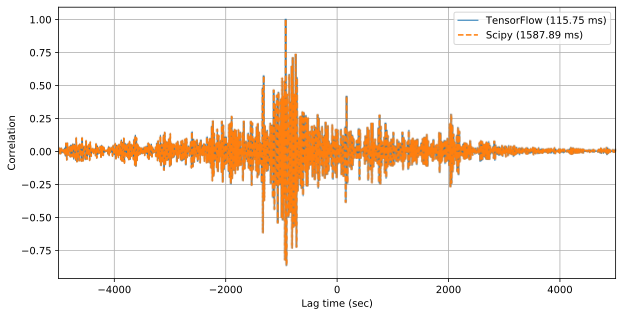

In [48]:
window_duration = 10000

tic = time.time()
xfft_tf = spectrogram_with_tf(t, x, window_duration)
xcorr_tf = xcorr_with_tf(xfft_tf)
time_tf = time.time() - tic

tic = time.time()
xfft_sp = spectrogram_with_sp(t, x, window_duration)
xcorr_sp = xcorr_with_sp(xfft_sp)
time_sp = time.time() - tic

fig, ax = plt.subplots(1, figsize=(10, 5))
tau = np.linspace(-window_duration, window_duration, xcorr_tf.shape[-1])

for i, (xcorr, exec_time) in enumerate(zip([xcorr_tf, xcorr_sp], [time_tf, time_sp])):
    b, a = signal.butter(4, 2 * [.05, .1] / fs, 'bandpass')
    xc = signal.filtfilt(b, a, xcorr[2, 1])
    xc /= np.abs(xc).max()
    label = ['TensorFlow ({:.2f} ms)', 'Scipy ({:.2f} ms)'][i].format(1e3 * exec_time)
    ax.plot(tau, xc, ['-', '--'][i], label=label, lw=[1., 1.5][i], rasterized=True)

ax.legend()
ax.grid()
ax.set_xlabel('Lag time (sec)')
ax.set_ylabel('Correlation')
ax.set_xlim([-5000, 5000])

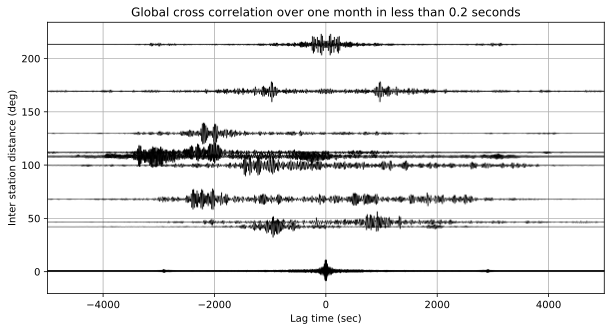

In [46]:
fig, ax = plt.subplots(1, figsize=(10, 5))
tau = np.linspace(-window_duration, window_duration, xcorr_tf.shape[-1])

xcorr = xcorr_tf
b, a = signal.butter(4, 2 * [.05, .1] / fs, 'bandpass')
for i in range(x.shape[0]):
    for j in range(i, x.shape[0]):
        xc = signal.filtfilt(b, a, xcorr[i, j])
        xc /= np.abs(xc).max()
        d = np.sqrt((lon[i] - lon[j]) ** 2 + (lat[i] - lat[j]) ** 2)
        ax.plot(tau, 10 * xc + d, rasterized=True, lw=.5, c='k')

ax.set_title('Global cross correlation over one month in less than 0.2 seconds')
ax.grid()
ax.set_xlabel('Lag time (sec)')
ax.set_ylabel('Inter station distance (deg)')
ax.set_xlim([-5000, 5000]);